# Classifiez automatiquement des biens de consommation

## Phase 3 : Utilisation d'un réseau de neurones

La classification de données n'a pas donné de bons résultats, parce qu'on n'a pas assez de représentations par image, on va utiliser un réseau de neurones (ResNet50) pour voir si ça donne de meilleurs résultats

In [1]:
import numpy as np
import os
import time
import pandas as pd

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten, MaxPooling2D

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

import umap


Using TensorFlow backend.
C:\Users\Salaheddine\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Salaheddine\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Salaheddine\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Salaheddine\anaconda3\lib\site-packages\tensorflow\py

In [2]:
data  = pd.read_feather('data.ft')

In [3]:
data.head()

,image,description,main category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


on commence par processer l'image pour l'utiliser comme input du resnet 50

In [4]:
def load_image(img_name):
    img_path = 'Flipkart/Images/'+ img_name
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
#    print (x.shape)
    x = np.expand_dims(x, axis=0)
#    print (x.shape)
    x = preprocess_input(x)
    return x
#    print('Input image shape:', x.shape)


In [5]:
load_image('6325b6870c54cd47be6ebfbffa620ec7.jpg')

array([[[[ -95.939    ,  -99.779    , -103.68     ],
         [  15.060997 ,    7.2210007,    9.32     ],
         [  58.060997 ,   51.221    ,   51.32     ],
         ...,
         [ 121.061    ,  113.221    ,  109.32     ],
         [  43.060997 ,   33.221    ,   34.32     ],
         [ 121.061    ,  112.221    ,  110.32     ]],

        [[  33.060997 ,   30.221    ,   30.32     ],
         [  58.060997 ,   49.221    ,   47.32     ],
         [  60.060997 ,   49.221    ,   52.32     ],
         ...,
         [ 119.061    ,  110.221    ,  108.32     ],
         [ 120.061    ,  111.221    ,  109.32     ],
         [ 119.061    ,  110.221    ,  108.32     ]],

        [[  53.060997 ,   49.221    ,   51.32     ],
         [  47.060997 ,   40.221    ,   40.32     ],
         [  55.060997 ,   48.221    ,   48.32     ],
         ...,
         [ 118.061    ,  109.221    ,  107.32     ],
         [ 119.061    ,  110.221    ,  108.32     ],
         [ 118.061    ,  109.221    ,  107.32     ]],

In [6]:
img_data_list=[]
for img in data['image']:
    img_data_list.append(load_image(img))


C:\Users\Salaheddine\anaconda3\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [7]:
img_data = np.array(img_data_list)
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(1050, 1, 224, 224, 3)
(1, 1050, 224, 224, 3)
(1050, 224, 224, 3)


In [8]:
# Initialisation du dernier layer sans la dernière couche fully connected
image_input = Input(shape=(224, 224, 3))

model = ResNet50(include_top=False,weights='imagenet', input_shape=(224,224,3))
model.summary()

C:\Users\Salaheddine\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [9]:
# On construit les dernières couches du modèle, un flatten, puis un dense avec notre nombre de catégories
headModel = model.output
#headModel = MaxPooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(data['main category'].nunique(), activation="softmax")(headModel)

In [10]:
# Et finalement on aggrègre tout pour obtenir notre nouveau modèle
custom_model = Model(inputs=model.input, outputs=headModel)

In [11]:
custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
# on entraine pas les couches originales du resnet50, on va juste entrainer la dernière couche fully connected
for layer in model.layers:
    layer.trainable = False
custom_model.layers[-1].trainable

True

In [13]:
# On compilel notre modèle avant entrainement
opt = Adam(learning_rate=0.01)
custom_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
# On doit bien evidemment encoder toutes les catgégories avant
enc = OneHotEncoder(handle_unknown='ignore')
Y = enc.fit_transform(data[['main category']])


In [14]:
# on sépare en training / testing test
X_train, X_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.2, random_state=42)

In [15]:
# On rajoute un early stopping 
callback = EarlyStopping(monitor='accuracy', patience=2)
# puis on peut commencer à fiter le modèle
t=time.time()
hist = custom_model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])
print('Training time: %s' % (t - time.time()))


Train on 840 samples, validate on 210 samples
Epoch 1/15
840/840 [==============================] - 403s 480ms/step - loss: 53.1295 - accuracy: 0.6774 - val_loss: 43.1753 - val_accuracy: 0.8286
Epoch 2/15
840/840 [==============================] - 398s 473ms/step - loss: 6.8903 - accuracy: 0.9452 - val_loss: 49.4528 - val_accuracy: 0.8286
Epoch 3/15
840/840 [==============================] - 386s 459ms/step - loss: 2.7522 - accuracy: 0.9679 - val_loss: 42.9255 - val_accuracy: 0.8429
Epoch 4/15
840/840 [==============================] - 383s 456ms/step - loss: 0.8445 - accuracy: 0.9869 - val_loss: 48.4978 - val_accuracy: 0.8048
Epoch 5/15
840/840 [==============================] - 382s 455ms/step - loss: 2.3160 - accuracy: 0.9821 - val_loss: 46.8252 - val_accuracy: 0.8333
Epoch 6/15
840/840 [==============================] - 387s 460ms/step - loss: 1.3184 - accuracy: 0.9833 - val_loss: 68.7316 - val_accuracy: 0.8143
Training time: -2340.0963010787964


In [38]:
# puis on teste sur notre jeu de test
(loss, accuracy) = custom_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

210/210 [==============================] - 147s 702ms/step
[INFO] loss=68.7316, accuracy: 81.4286%


In [22]:
import matplotlib.pyplot as plt

# on peut visuaiser l'évolution de nos différents indicateurs

def plot_loss_acc(hist):
    # visualizing losses and accuracy
    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['accuracy']
    val_acc=hist.history['val_accuracy']
    xc=range(len(train_loss))

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    plt.style.use(['classic'])

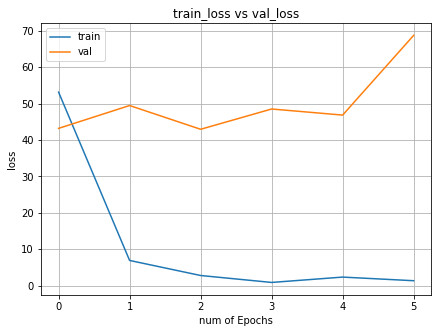

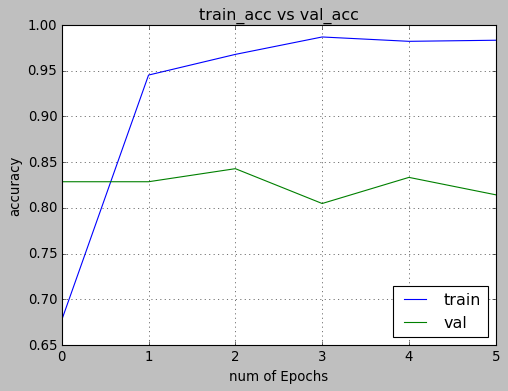

In [23]:
plot_loss_acc(hist)

Notre modèle actuel est beaucoup mieux pour l'analyse visuelle, sauf qu'il overfitte un peu, et le résultat de loss est énorme pour la validation, on va essayer de l'optimiser notemment en rajoutant des couches de DropOut

In [27]:
model = ResNet50(weights='imagenet',include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [28]:
last_layer = model.output

In [29]:
#On va utiliser un average pooling pour récupérer nos données

x = GlobalAveragePooling2D()(last_layer)

In [30]:
# et on ajoute des couches fully connected intercalées par des couches de Dropout pour éviter le sur apprentissage 
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)

In [31]:
# finalement on ajoute une couche softmax pour catégoriser nos données
out = Dense(data['main category'].nunique(), activation='softmax',name='output_layer')(x)

In [32]:
custom_model2 = Model(inputs=model.input, outputs=out)

custom_model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [33]:

for layer in model.layers:
    layer.trainable = False

opt = Adam(learning_rate=0.01)
custom_model2.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [35]:
# On rajoute un early stopping 
callback = EarlyStopping(monitor='accuracy', patience=2)
# On entraine notre nouveau modèle
t=time.time()
hist = custom_model2.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])
print('Training time: %s' % (t - time.time()))

Train on 840 samples, validate on 210 samples
Epoch 1/12
840/840 [==============================] - 395s 470ms/step - loss: 5.5268 - accuracy: 0.4369 - val_loss: 0.9334 - val_accuracy: 0.7048
Epoch 2/12
840/840 [==============================] - 402s 479ms/step - loss: 1.2224 - accuracy: 0.6667 - val_loss: 0.7980 - val_accuracy: 0.7857
Epoch 3/12
840/840 [==============================] - 399s 475ms/step - loss: 0.9547 - accuracy: 0.7119 - val_loss: 0.8582 - val_accuracy: 0.7905
Epoch 4/12
840/840 [==============================] - 373s 444ms/step - loss: 0.9385 - accuracy: 0.7250 - val_loss: 0.7553 - val_accuracy: 0.8381
Epoch 5/12
840/840 [==============================] - 371s 442ms/step - loss: 0.8319 - accuracy: 0.7393 - val_loss: 0.9967 - val_accuracy: 0.8000
Epoch 6/12
840/840 [==============================] - 371s 442ms/step - loss: 0.9615 - accuracy: 0.7452 - val_loss: 0.9096 - val_accuracy: 0.7810
Epoch 7/12
840/840 [==============================] - 373s 444ms/step - loss: 

In [36]:
(loss, accuracy) = custom_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

210/210 [==============================] - 73s 348ms/step
[INFO] loss=1.0118, accuracy: 77.6190%


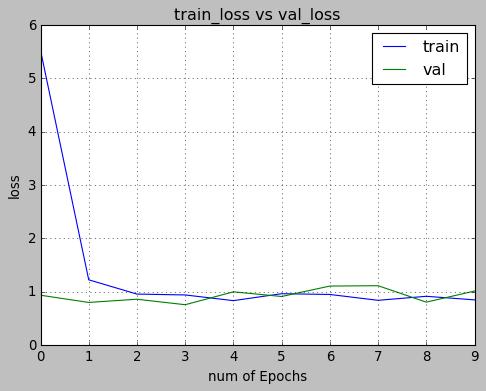

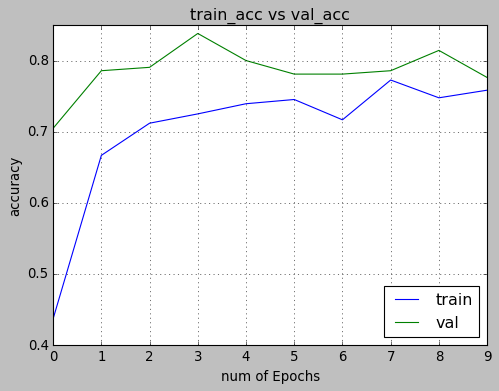

In [37]:
plot_loss_acc(hist)

Notre modèle n'overfitte pas du tout, au contraire, le score de validation est légèrement supérieur à celui du training
le loss du training / validation sont tous les deux bas et du même ordre de grandeur, donc même si le score est plus bas que celui utilisé plus haut on préferera ce modèle 